In [1]:
import os
import random
import cv2
from PIL import Image
import numpy as np
import supervision as sv
import pandas as pd
import joblib
import yolov5
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import tensorflow as tf

In [2]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [3]:
model_path = "./saved_models/fish_model_volov5_29-01-24.pt"
fish_model = yolov5.load(model_path)
fish_model.conf = 0.3

YOLOv5  2024-1-19 Python-3.10.11 torch-2.1.1+cpu CPU

c:\Kodprojekt\sick_fishes\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fusing layers... 
Model summary: 291 layers, 20871318 parameters, 0 gradients, 48.2 GFLOPs
Adding AutoShape... 


In [4]:
df = pd.read_csv("./dataset/SB-FishDisease.csv")

In [5]:
df['target'].value_counts()

target
disease    268
healthy    155
Name: count, dtype: int64

In [6]:
df['sickness'].unique()

array(['bacterial_diseases _aeromoniasis ', 'bacterial_gill disease', 'bacterial_red disease', 'fungal_diseases_saprolegniasis', 'healthy_fish', 'healthy_gills', 'parasitic_diseases', 'viral_diseases_white_tail_disease'], dtype=object)

In [7]:
df

,path,sickness,target
0,./dataset/SB-FishDisease/Bacterial diseases - ...,bacterial_diseases _aeromoniasis,disease
1,./dataset/SB-FishDisease/Bacterial diseases - ...,bacterial_diseases _aeromoniasis,disease
2,./dataset/SB-FishDisease/Bacterial diseases - ...,bacterial_diseases _aeromoniasis,disease
3,./dataset/SB-FishDisease/Bacterial diseases - ...,bacterial_diseases _aeromoniasis,disease
4,./dataset/SB-FishDisease/Bacterial diseases - ...,bacterial_diseases _aeromoniasis,disease
...,...,...,...
418,./dataset/SB-FishDisease/Viral diseases White ...,viral_diseases_white_tail_disease,disease
419,./dataset/SB-FishDisease/Viral diseases White ...,viral_diseases_white_tail_disease,disease
420,./dataset/SB-FishDisease/Viral diseases White ...,viral_diseases_white_tail_disease,disease
421,./dataset/SB-FishDisease/Viral diseases White ...,viral_diseases_white_tail_disease,disease


In [8]:
augmented_df = pd.DataFrame(columns=['path', 'sickness', 'target'])
augmented_images = []

output_folder = './dataset/cropped_images'
os.makedirs(output_folder, exist_ok=True)

cropped_count = 0
non_cropped_count = 0

for index, row in df.iterrows():
    image_path = row['path']
    file_name, file_extension = os.path.splitext(os.path.basename(image_path))
    sickness = row['sickness']
    target = row['target']
    if sickness not in ['bacterial_gill disease', 'healthy_gills']:
        new_path = f"{output_folder}/{file_name}.jpg"
        original_image = cv2.imread(image_path)
        image = Image.fromarray(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        yolo_result = fish_model(image)
        yolo_pred = yolo_result.pandas().xyxy[0]
        if len(yolo_pred) > 0:
            number = 1
            for _, yolo_pred in yolo_pred.iterrows():
                bbox = yolo_pred[['xmin', 'ymin', 'xmax', 'ymax']].astype(int).tolist()
                crop_coordinates = (bbox[0],bbox[1],bbox[2],bbox[3])
                cropped_image = image.crop(crop_coordinates)
                new_path = f"{output_folder}/cropped_{file_name}_{number}.jpg"
                cropped_image.save(new_path)
                cropped_count += 1
                number += 1
        else:
            image.save(new_path)
            non_cropped_count += 1
        augmented_data = {
            'path': new_path,
            'sickness': sickness,
            'target': target
        }
        augmented_images.append(augmented_data)
augmented_df = pd.concat([augmented_df, pd.DataFrame(augmented_images)], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: './dataset/SB-FishDisease/Bacterial Red disease\\Bacterial_Red disease_14.jpg'

In [ ]:
augmented_df

In [11]:
print(cropped_count, non_cropped_count, sep='\n')

402
7


In [33]:
augmented_df= pd.read_csv("./dataset/cropped_images/augmented_data.csv")

In [252]:
def random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("Inga bilder hittades i mappen.")
        return None

    random_image = random.choice(image_files)

    img_path = os.path.join(folder_path, random_image)

    return img_path

In [280]:
folder_path = './dataset/test_img/Healthy_fishies/Sea Bass/'
test_image_path = random_image(folder_path)
# test_image_path = 'dataset\SB-FishDisease\Healthy Fish\Healthy_Fish_69.jpeg'
original_image = cv2.imread(test_image_path)
image = Image.fromarray(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

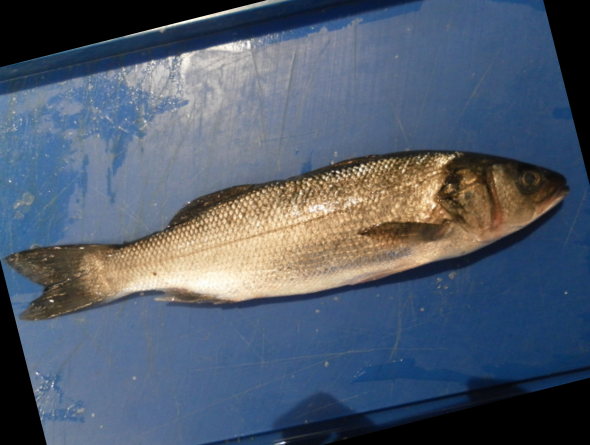

In [281]:
display(image)

### Om man testar en färdig modell från roboflows hemsida:

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="fjIBiSxI8p0lRxRjtzMu")
# project = rf.workspace().project("fish-detection-ypxel")
# model = project.version(2).model

# result = model.predict(image_path, confidence=40, overlap=30).json()
# prediction = result['predictions'][0]
# x, y, w, h = int(prediction['x']), int(prediction['y']), int(prediction['width']), int(prediction['height'])
# new_path = f"{output_folder}/cropped_{sickness}_{index}.jpg"
# x= x-(w/2)
# y= y-(h/2)
# crop_coordinates = (x,y,x+w,y+h)

In [9]:
def prepare_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

       xmin       ymin        xmax        ymax  confidence  class  name
0  1.835428  22.928968  209.834091  185.107376    0.925686      0  fish
Fish detected
1 22 209 185


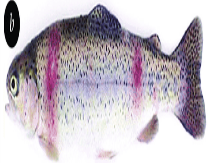

NameError: name 'loaded_model' is not defined

In [10]:
yolo_result = fish_model(image)
yolo_preds = yolo_result.pandas().xyxy[0]

print(yolo_preds)

if len(yolo_preds) > 0:
    print(f"Fish detected")
    
    for _, yolo_pred in yolo_preds.iterrows():
        bbox = yolo_pred[['xmin', 'ymin', 'xmax', 'ymax']].astype(int).tolist()
        # roi = original_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        print(bbox[0],bbox[1], bbox[2],bbox[3])
        crop_coordinates = (bbox[0],bbox[1],bbox[2],bbox[3])
        cropped_image = image.crop(crop_coordinates)

        cropped_image.save('test.jpg')

        display(cropped_image)

        cropped_image_array = img_to_array(cropped_image)
        cropped_image_array = tf.image.resize(cropped_image_array, (64, 64))
        cropped_image_array = np.expand_dims(cropped_image_array, axis=0)

        # Gör prediktion med modellen
        prediction = loaded_model.predict(cropped_image_array)

        predicted_class_index = np.argmax(prediction[0])
        class_labels = ["Diseased", "Healthy"]
        predicted_class_label = class_labels[predicted_class_index]
        confidence_score = prediction[0][predicted_class_index]

        print(predicted_class_label, confidence_score)

        # Preprocessing för sick model  

        # second_model_output = sick_model.predict([........])

        # print(f"Prediction for ROI: Class {second_model_output[0]}")

else:
    print(f"No fish detected")


In [11]:
loaded_model = load_model('./saved_models/cnn_model_more_data_17-1-24.h5')

In [12]:
def prepare_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

In [13]:
test_folder_path = './dataset/test_img/Healthy_fishies/'

# Dictionary för att lagra noggrannheter per undermapp
accuracy_per_class = {}

# Loopa igenom varje undermapp i testmappen
for subdir, dirs, files in os.walk(test_folder_path):
    # Ignorera rotmappen
    if subdir == test_folder_path:
        continue

    # Lista för att lagra sanna klasser och förutsagda klasser för den aktuella undermappen
    true_labels = []
    predicted_labels = []

    for file in files:
        # Skapa den fullständiga sökvägen till varje bild
        img_path = os.path.join(subdir, file)
        original_image = cv2.imread(img_path)
        image = Image.fromarray(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        yolo_result = fish_model(image)
        yolo_preds = yolo_result.pandas().xyxy[0]
        if len(yolo_preds) > 0:
            for _, yolo_pred in yolo_preds.iterrows():
                bbox = yolo_pred[['xmin', 'ymin', 'xmax', 'ymax']].astype(int).tolist()
                # roi = original_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
                # print(bbox[0],bbox[1], bbox[2],bbox[3])
                crop_coordinates = (bbox[0],bbox[1],bbox[2],bbox[3])
                cropped_image = image.crop(crop_coordinates)

                # cropped_image.save('test.jpg')

                # display(cropped_image)

                cropped_image_array = img_to_array(cropped_image)
                cropped_image_array = tf.image.resize(cropped_image_array, (64, 64))
                cropped_image_array = np.expand_dims(cropped_image_array, axis=0)

                # Gör prediktion med modellen
                prediction = loaded_model.predict(cropped_image_array)

                predicted_class_index = np.argmax(prediction[0])
                class_labels = ["Diseased", "Healthy"]
                predicted_class_label = class_labels[predicted_class_index]
                confidence_score = prediction[0][predicted_class_index]

                true_class = os.path.basename(subdir)
                true_labels.append('Healthy')
                predicted_labels.append(predicted_class_label)

                print(predicted_class_label, confidence_score)
        else:
            print('No fish')
            test_image = prepare_images([img_path])

            # Gör prediktion med modellen
            prediction = loaded_model.predict(test_image)

            # Bestäm sann klass från undermappens namn
            true_class = os.path.basename(subdir)

            # Bestäm förutsagd klass och spara i listor
            predicted_class_index = np.argmax(prediction[0])
            class_labels = ["Diseased", "Healthy"]
            predicted_class_label = class_labels[predicted_class_index]

            true_labels.append('Healthy')
            predicted_labels.append(predicted_class_label)

    # Beräkna noggrannhet för den aktuella undermappen
    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
    accuracy_per_class[true_class] = accuracy

1/1 [==============================] - 0s 75ms/step
Healthy 1.0
1/1 [==============================] - 0s 13ms/step
Diseased 0.98540556
1/1 [==============================] - 0s 13ms/step
Healthy 1.0
1/1 [==============================] - 0s 15ms/step
Healthy 0.70915776
1/1 [==============================] - 0s 19ms/step
Healthy 0.9615842
1/1 [==============================] - 0s 15ms/step
Diseased 1.0
1/1 [==============================] - 0s 14ms/step
Diseased 0.99999917
1/1 [==============================] - 0s 14ms/step
Diseased 1.0
1/1 [==============================] - 0s 13ms/step
Diseased 0.92535543
No fish
1/1 [==============================] - 0s 15ms/step
Diseased 0.9158497
1/1 [==============================] - 0s 12ms/step
Healthy 0.9998504
1/1 [==============================] - 0s 15ms/step
Diseased 0.61674786
1/1 [==============================] - 0s 15ms/step
Diseased 0.9999994
1/1 [==============================] - 0s 13ms/step
Diseased 0.5480953
1/1 [=================

In [14]:
accuracy_per_class

{'Black Sea Sprat': 0.2549019607843137,
 'Gilt-Head Bream': 0.4406779661016949,
 'Hourse Mackerel': 0.39285714285714285,
 'Red Mullet': 0.3125,
 'Red Sea Bream': 0.29411764705882354,
 'Sea Bass': 0.375,
 'Striped Red Mullet': 0.2909090909090909}